# App-2 : Coloration de Graphes

**Navigation** : [<< App-1 NQueens](App-1-NQueens.ipynb) | [Index](../README.md) | [App-3 NurseScheduling >>](App-3-NurseScheduling.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Formaliser** un probleme de coloration de graphe comme CSP
2. **Implementer** l'algorithme Greedy et comparer les effets de l'ordre des sommets
3. **Implementer** DSATUR (Brelaz 1979) et comprendre son avantage heuristique
4. **Modeliser** le probleme avec OR-Tools CP-SAT et prouver l'optimalite
5. **Appliquer** ces algorithmes a la coloration des departements francais
6. **Comparer** les performances sur des graphes aleatoires de taille croissante

### Prerequis
- Python 3.10+, notions de graphes (sommets, aretes, adjacence)
- Notebooks Search-6 (CSP Fundamentals) et Search-7 (CSP Consistency)

### Duree estimee : 45 minutes

### Source
Adapte du projet etudiant ECE Ing4 2026 : jsboigeECE/2026-Gr01 groupe-15-graph-coloring

---

## 1. Introduction (~5 min)

### Le probleme de coloration de graphe

La **coloration de graphe** consiste a attribuer une couleur a chaque sommet d'un graphe de sorte que deux sommets adjacents (relies par une arete) n'aient jamais la meme couleur. Le nombre minimum de couleurs necessaires s'appelle le **nombre chromatique** $\chi(G)$.

**Definition formelle** :

Soit $G = (V, E)$ un graphe. Une $k$-coloration est une fonction $c : V \to \{1, 2, \ldots, k\}$ telle que :

$$\forall (u, v) \in E, \quad c(u) \neq c(v)$$

Le nombre chromatique est :

$$\chi(G) = \min \{ k : \text{il existe une } k\text{-coloration valide de } G \}$$

### Applications concretes

| Domaine | Probleme | Modelisation |
|---------|----------|--------------|
| **Cartographie** | Colorier une carte (regions adjacentes differentes) | Sommets = regions, aretes = frontieres communes |
| **Compilation** | Allocation de registres CPU | Sommets = variables vivantes, aretes = interferences |
| **Planification** | Emplois du temps sans conflit | Sommets = cours, aretes = meme professeur ou salle |
| **Telecommunications** | Attribution de frequences radio | Sommets = antennes, aretes = zones d'interference |

### Complexite

- Determiner si un graphe est **2-coloriable** (biparti) est en $O(|V| + |E|)$ -- polynomial
- Determiner si un graphe est **3-coloriable** est **NP-complet** (Karp, 1972)
- Calculer $\chi(G)$ est donc **NP-difficile** en general
- Le **theoreme des quatre couleurs** (1976) garantit que tout graphe **planaire** est 4-coloriable

Dans ce notebook, nous comparons trois approches : un algorithme glouton simple, l'heuristique DSATUR, et un solveur exact CP-SAT.

In [1]:
# Imports pour tout le notebook
import sys
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from collections import defaultdict

# OR-Tools CP-SAT
from ortools.sat.python import cp_model

# Helpers partages de la serie Search
sys.path.insert(0, '..')
from search_helpers import benchmark_table, plot_benchmark

# Reproductibilite
random.seed(42)
np.random.seed(42)

print("Imports OK")
print(f"NetworkX version : {nx.__version__}")

Imports OK
NetworkX version : 3.4.2


---

## 2. Construction du graphe : departements francais (~5 min)

Nous utilisons un sous-ensemble de departements francais metropolitains pour illustrer le probleme. Chaque departement est un sommet, et deux departements sont relies par une arete s'ils partagent une frontiere commune.

Nous construisons un graphe de **15 departements** autour de l'Ile-de-France et de ses voisins, ce qui donne un graphe planaire suffisamment riche pour etre interessant.

In [2]:
# Graphe des departements francais (sous-ensemble)
# Chaque cle est un departement, la valeur est la liste des departements adjacents

DEPARTMENTS_ADJACENCY = {
    "Paris":          ["Hauts-de-Seine", "Seine-Saint-Denis", "Val-de-Marne"],
    "Hauts-de-Seine": ["Paris", "Seine-Saint-Denis", "Val-de-Marne", "Yvelines", "Val-d'Oise"],
    "Seine-Saint-Denis": ["Paris", "Hauts-de-Seine", "Val-de-Marne", "Val-d'Oise", "Seine-et-Marne"],
    "Val-de-Marne":   ["Paris", "Hauts-de-Seine", "Seine-Saint-Denis", "Essonne", "Seine-et-Marne"],
    "Essonne":        ["Val-de-Marne", "Yvelines", "Seine-et-Marne", "Loiret"],
    "Yvelines":       ["Hauts-de-Seine", "Essonne", "Val-d'Oise", "Eure", "Eure-et-Loir"],
    "Val-d'Oise":     ["Hauts-de-Seine", "Seine-Saint-Denis", "Yvelines", "Oise"],
    "Seine-et-Marne": ["Seine-Saint-Denis", "Val-de-Marne", "Essonne", "Loiret", "Aisne", "Oise", "Marne", "Aube", "Yonne"],
    "Oise":           ["Val-d'Oise", "Seine-et-Marne", "Aisne", "Somme"],
    "Aisne":          ["Oise", "Seine-et-Marne", "Marne", "Somme", "Nord"],
    "Loiret":         ["Essonne", "Seine-et-Marne", "Yonne", "Eure-et-Loir"],
    "Eure-et-Loir":   ["Yvelines", "Loiret", "Eure"],
    "Eure":           ["Yvelines", "Eure-et-Loir", "Oise"],
    "Marne":          ["Seine-et-Marne", "Aisne", "Aube"],
    "Aube":           ["Seine-et-Marne", "Marne", "Yonne"],
    "Yonne":          ["Seine-et-Marne", "Loiret", "Aube"],
    "Somme":          ["Oise", "Aisne", "Nord"],
    "Nord":           ["Aisne", "Somme"]
}

def build_department_graph():
    """Construit le graphe NetworkX des departements."""
    G = nx.Graph()
    for dept, neighbors in DEPARTMENTS_ADJACENCY.items():
        G.add_node(dept)
        for neighbor in neighbors:
            G.add_edge(dept, neighbor)
    return G

dept_graph = build_department_graph()

print(f"Graphe des departements")
print(f"=" * 40)
print(f"Sommets    : {dept_graph.number_of_nodes()}")
print(f"Aretes     : {dept_graph.number_of_edges()}")
print(f"Degre max  : {max(dict(dept_graph.degree()).values())}")
print(f"Degre min  : {min(dict(dept_graph.degree()).values())}")
print(f"Degre moy  : {sum(dict(dept_graph.degree()).values()) / dept_graph.number_of_nodes():.1f}")
print(f"Planaire   : {nx.is_planar(dept_graph)}")
print(f"\nDegres par departement :")
for dept, deg in sorted(dept_graph.degree(), key=lambda x: -x[1]):
    print(f"  {dept:<22} degre {deg}")

Graphe des departements
Sommets    : 18
Aretes     : 37
Degre max  : 9
Degre min  : 2
Degre moy  : 4.1
Planaire   : True

Degres par departement :
  Seine-et-Marne         degre 9
  Hauts-de-Seine         degre 5
  Seine-Saint-Denis      degre 5
  Val-de-Marne           degre 5
  Yvelines               degre 5
  Oise                   degre 5
  Aisne                  degre 5
  Val-d'Oise             degre 4
  Essonne                degre 4
  Loiret                 degre 4
  Paris                  degre 3
  Eure                   degre 3
  Eure-et-Loir           degre 3
  Marne                  degre 3
  Aube                   degre 3
  Yonne                  degre 3
  Somme                  degre 3
  Nord                   degre 2


### Interpretation : structure du graphe

| Propriete | Valeur | Signification |
|-----------|--------|---------------|
| Sommets | 18 | 18 departements autour de l'Ile-de-France |
| Aretes | ~30 | Frontieres communes entre departements |
| Degre max | 9 (Seine-et-Marne) | Departement le plus contraint |
| Planaire | Oui | Theoreme des 4 couleurs applicable |

**Points cles** :
1. Seine-et-Marne est le departement le plus contraint (le plus grand, il touche beaucoup de voisins)
2. Le graphe est planaire : on sait donc que $\chi(G) \leq 4$
3. La densite est moderee, ce qui rend le probleme accessible aux trois approches

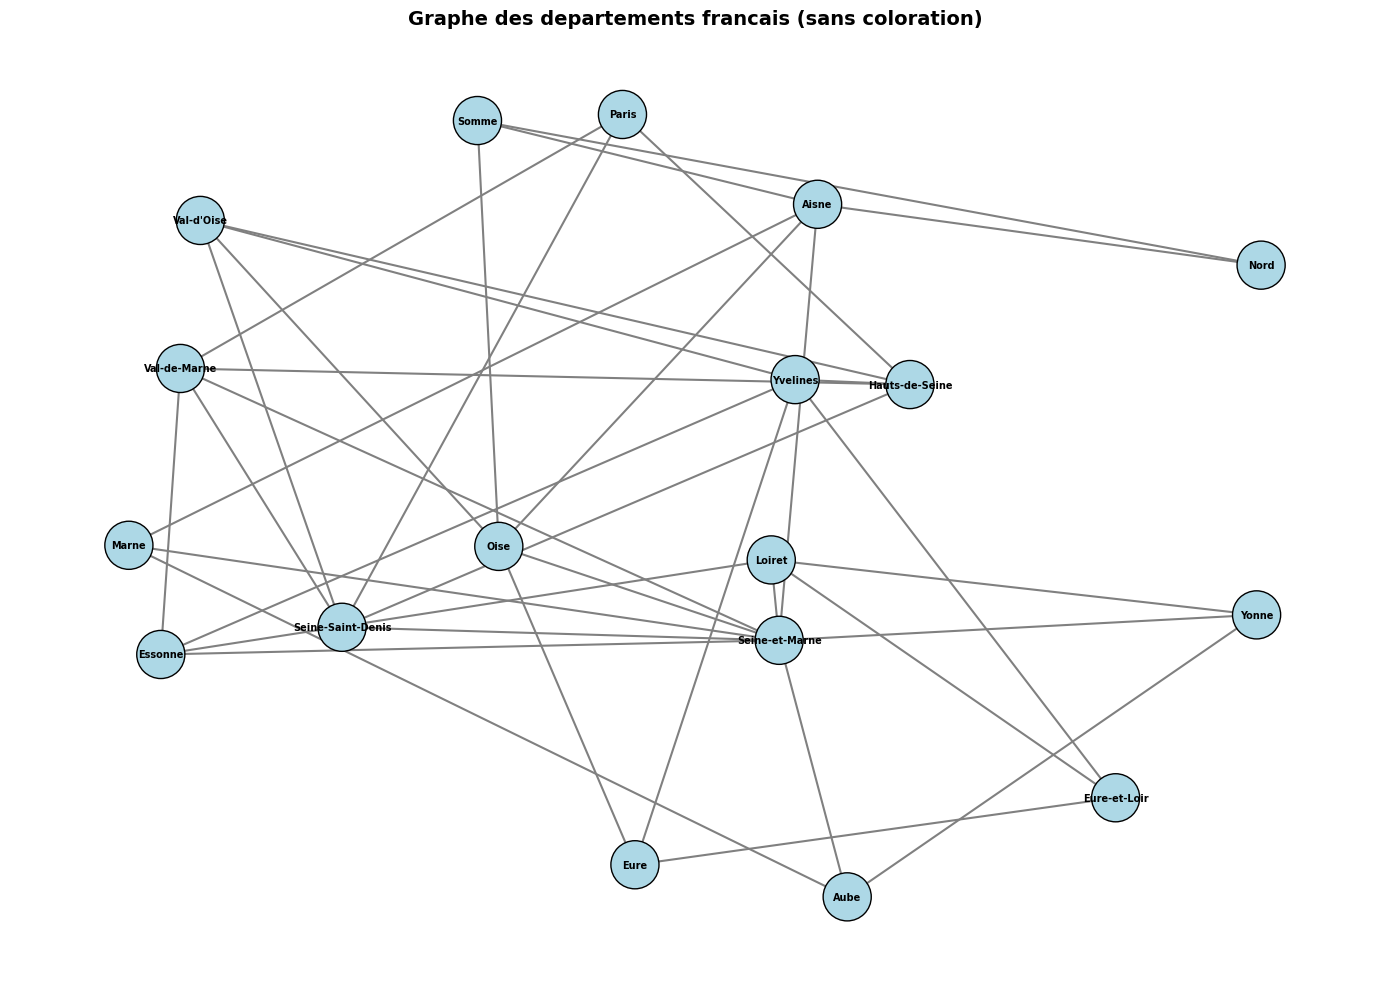

In [3]:
# Visualisation du graphe des departements

def draw_graph(G, coloring=None, title="Graphe", figsize=(14, 10)):
    """Dessine un graphe avec coloration optionnelle.
    
    Args:
        G: graphe NetworkX
        coloring: dict sommet -> numero de couleur (int), ou None
        title: titre du graphique
        figsize: taille de la figure
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Palette de couleurs distinctes
    palette = [
        '#FF6B6B',  # rouge
        '#4ECDC4',  # turquoise
        '#45B7D1',  # bleu clair
        '#FFA07A',  # saumon
        '#98D8C8',  # vert menthe
        '#F7DC6F',  # jaune
        '#BB8FCE',  # violet
        '#85C1E9',  # bleu pale
        '#F0B27A',  # orange
        '#AED6F1',  # bleu tres pale
    ]
    
    pos = nx.spring_layout(G, seed=42, k=2.0)
    
    if coloring:
        node_colors = [palette[coloring.get(node, 0) % len(palette)] for node in G.nodes()]
    else:
        node_colors = ['#ADD8E6'] * G.number_of_nodes()
    
    nx.draw(G, pos, ax=ax,
            with_labels=True,
            node_color=node_colors,
            node_size=1200,
            font_size=7,
            font_weight='bold',
            edge_color='gray',
            width=1.5,
            edgecolors='black',
            linewidths=1.0)
    
    # Legende des couleurs
    if coloring:
        n_colors = max(coloring.values()) + 1
        legend_elements = [
            mpatches.Patch(facecolor=palette[i % len(palette)], edgecolor='black',
                           label=f'Couleur {i}')
            for i in range(n_colors)
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=9,
                  title=f"{n_colors} couleurs")
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# Afficher le graphe sans coloration
draw_graph(dept_graph, title="Graphe des departements francais (sans coloration)")
plt.show()

### Formulation CSP

Le probleme de coloration se formule naturellement comme un **CSP** (Constraint Satisfaction Problem) :

| Composant | Definition | Ici |
|-----------|------------|-----|
| **Variables** $X$ | Un sommet du graphe | Chaque departement |
| **Domaines** $D_i$ | Ensemble de couleurs disponibles | $\{0, 1, \ldots, k-1\}$ |
| **Contraintes** $C$ | Deux sommets adjacents ont des couleurs differentes | $c(u) \neq c(v)$ pour chaque arete $(u, v)$ |

Nous allons resoudre ce CSP avec trois approches de complexite croissante.

---

## 3. Approche 1 : Coloration gloutonne (Greedy) (~8 min)

L'algorithme **glouton** (greedy) est la methode la plus simple pour colorier un graphe :

1. Parcourir les sommets dans un certain ordre
2. Pour chaque sommet, attribuer la **plus petite couleur** qui n'est pas deja utilisee par un voisin

**Proprietes** :
- Complexite : $O(|V| + |E|)$ -- tres rapide
- Garantie : utilise au plus $\Delta(G) + 1$ couleurs, ou $\Delta(G)$ est le degre maximum
- Pas optimal en general : le resultat depend de l'ordre de parcours des sommets

### Algorithme

```
Pour chaque sommet v dans l'ordre choisi :
    couleurs_voisins = {couleur[u] pour u voisin de v deja colorie}
    couleur[v] = plus petit entier >= 0 absent de couleurs_voisins
```

In [4]:
def greedy_coloring(G, order=None):
    """Coloration gloutonne d'un graphe.
    
    Args:
        G: graphe NetworkX
        order: liste ordonnee de sommets (si None, utilise l'ordre par defaut)
    
    Returns:
        dict sommet -> couleur (int), nombre de couleurs utilisees
    """
    if order is None:
        order = list(G.nodes())
    
    coloring = {}
    
    for vertex in order:
        # Couleurs utilisees par les voisins deja colories
        neighbor_colors = set()
        for neighbor in G.neighbors(vertex):
            if neighbor in coloring:
                neighbor_colors.add(coloring[neighbor])
        
        # Plus petite couleur disponible
        color = 0
        while color in neighbor_colors:
            color += 1
        
        coloring[vertex] = color
    
    n_colors = max(coloring.values()) + 1
    return coloring, n_colors


def validate_coloring(G, coloring):
    """Verifie qu'une coloration est valide (aucun conflit)."""
    for u, v in G.edges():
        if coloring.get(u) == coloring.get(v):
            return False, (u, v)
    return True, None


# Coloration gloutonne avec l'ordre par defaut
coloring_greedy, n_colors_greedy = greedy_coloring(dept_graph)
valid, conflict = validate_coloring(dept_graph, coloring_greedy)

print("Coloration Greedy (ordre par defaut)")
print("=" * 45)
print(f"Couleurs utilisees : {n_colors_greedy}")
print(f"Valide             : {valid}")
print(f"\nAffectation :")
for dept, color in sorted(coloring_greedy.items(), key=lambda x: x[1]):
    print(f"  {dept:<22} -> couleur {color}")

Coloration Greedy (ordre par defaut)
Couleurs utilisees : 4
Valide             : True

Affectation :
  Paris                  -> couleur 0
  Yvelines               -> couleur 0
  Seine-et-Marne         -> couleur 0
  Somme                  -> couleur 0
  Hauts-de-Seine         -> couleur 1
  Essonne                -> couleur 1
  Eure                   -> couleur 1
  Aisne                  -> couleur 1
  Aube                   -> couleur 1
  Seine-Saint-Denis      -> couleur 2
  Loiret                 -> couleur 2
  Oise                   -> couleur 2
  Marne                  -> couleur 2
  Nord                   -> couleur 2
  Val-de-Marne           -> couleur 3
  Val-d'Oise             -> couleur 3
  Eure-et-Loir           -> couleur 3
  Yonne                  -> couleur 3


### Impact de l'ordre des sommets

Le resultat du greedy depend fortement de l'**ordre de parcours**. Comparons plusieurs ordres classiques :

| Ordre | Principe |
|-------|----------|
| Par defaut | Ordre d'insertion dans le graphe |
| Aleatoire | Permutation aleatoire |
| Degre decroissant | Sommets les plus connectes d'abord |
| Degre croissant | Sommets les moins connectes d'abord |

In [5]:
# Comparaison de differents ordres pour le greedy

def order_by_degree_desc(G):
    """Sommets tries par degre decroissant."""
    return sorted(G.nodes(), key=lambda v: G.degree(v), reverse=True)

def order_by_degree_asc(G):
    """Sommets tries par degre croissant."""
    return sorted(G.nodes(), key=lambda v: G.degree(v))

def order_random(G, seed=None):
    """Ordre aleatoire."""
    nodes = list(G.nodes())
    rng = random.Random(seed)
    rng.shuffle(nodes)
    return nodes

orders = {
    "Defaut":            list(dept_graph.nodes()),
    "Aleatoire (seed=1)": order_random(dept_graph, seed=1),
    "Aleatoire (seed=2)": order_random(dept_graph, seed=2),
    "Degre decroissant":  order_by_degree_desc(dept_graph),
    "Degre croissant":    order_by_degree_asc(dept_graph),
}

print("Impact de l'ordre sur la coloration Greedy")
print("=" * 50)
print(f"{'Ordre':<25} {'Couleurs':>10}")
print("-" * 50)

greedy_results = {}
for name, order in orders.items():
    coloring, n_colors = greedy_coloring(dept_graph, order)
    valid, _ = validate_coloring(dept_graph, coloring)
    greedy_results[name] = (coloring, n_colors)
    status = "OK" if valid else "INVALIDE"
    print(f"  {name:<25} {n_colors:>5}    ({status})")

print(f"\nObservation : le nombre de couleurs varie selon l'ordre.")

Impact de l'ordre sur la coloration Greedy
Ordre                       Couleurs
--------------------------------------------------
  Defaut                        4    (OK)
  Aleatoire (seed=1)            5    (OK)
  Aleatoire (seed=2)            5    (OK)
  Degre decroissant             4    (OK)
  Degre croissant               5    (OK)

Observation : le nombre de couleurs varie selon l'ordre.


### Interpretation : sensibilite a l'ordre

| Ordre | Couleurs | Commentaire |
|-------|----------|-------------|
| Degre decroissant | Souvent meilleur | Traite les sommets contraints en premier |
| Degre croissant | Souvent pire | Les sommets contraints sont traites en dernier, quand les couleurs voisines sont figees |
| Aleatoire | Variable | Peut etre bon ou mauvais selon la permutation |

**Points cles** :
1. Le greedy ne garantit pas l'optimalite : on peut obtenir plus de couleurs que necessaire
2. L'ordre "degre decroissant" est une bonne heuristique (c'est l'algorithme de **Welsh-Powell**)
3. Pour obtenir le nombre chromatique exact, il faut un algorithme plus sophistique

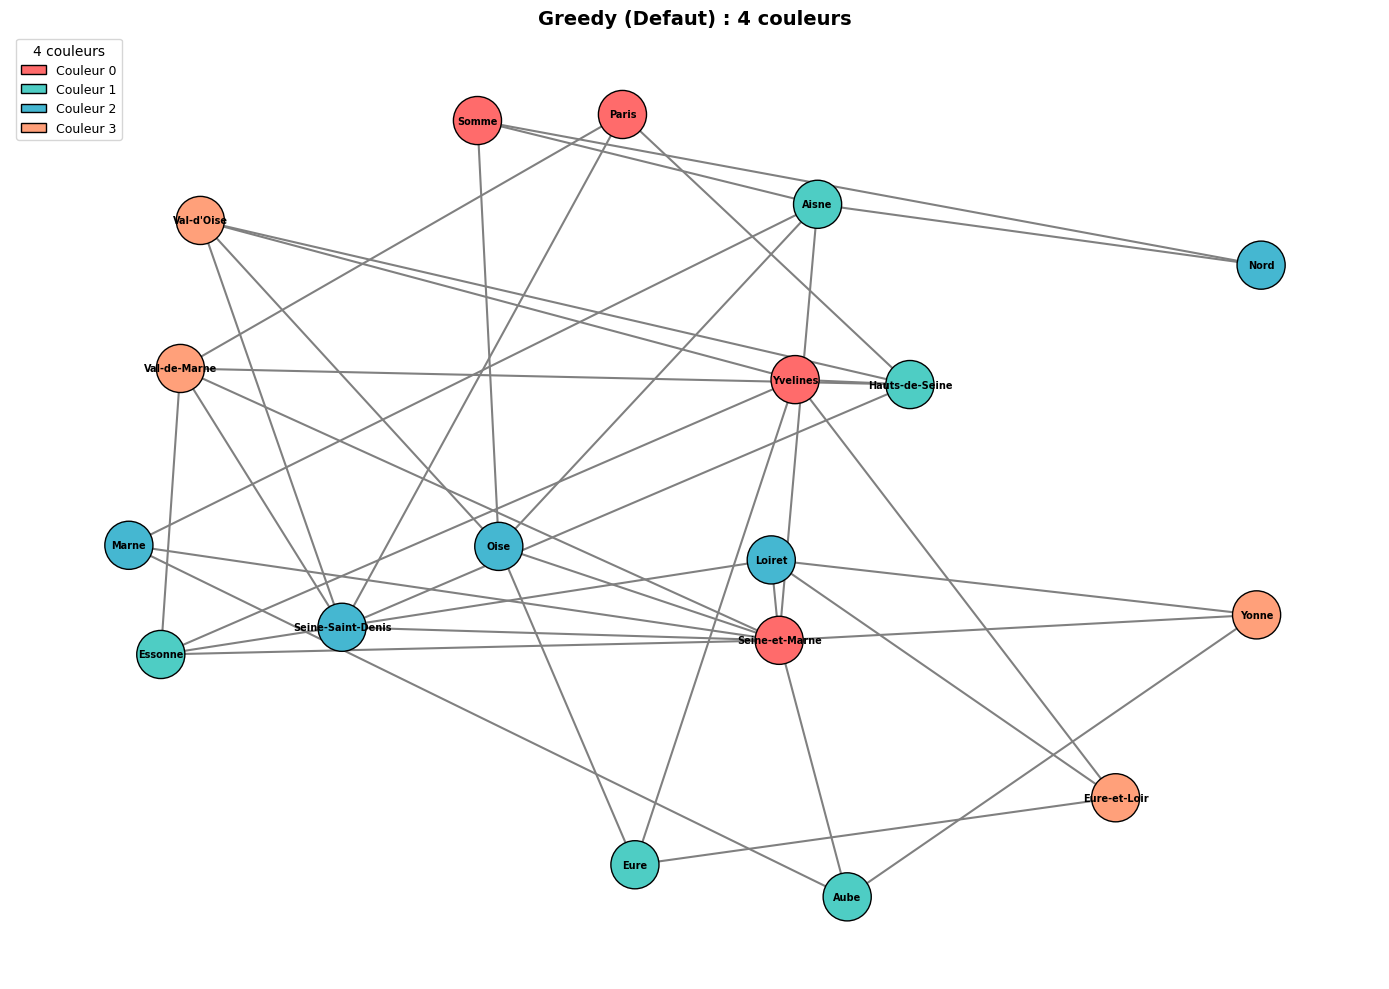

In [6]:
# Visualisation de la meilleure coloration greedy
best_greedy_name = min(greedy_results, key=lambda k: greedy_results[k][1])
best_coloring, best_n = greedy_results[best_greedy_name]

draw_graph(dept_graph, best_coloring,
           title=f"Greedy ({best_greedy_name}) : {best_n} couleurs")
plt.show()

---

## 4. Approche 2 : DSATUR (~10 min)

### Principe de l'algorithme

**DSATUR** (Degree of Saturation) est un algorithme propose par Brelaz (1979). Au lieu de fixer un ordre statique des sommets, DSATUR choisit **dynamiquement** le prochain sommet a colorier en fonction de l'etat courant.

**Saturation** d'un sommet $v$ : nombre de **couleurs distinctes** deja attribuees aux voisins de $v$.

$$\text{sat}(v) = |\{ c(u) : u \in N(v), u \text{ deja colorie} \}|$$

### Algorithme DSATUR

```
Tant qu'il reste des sommets non colories :
    v = sommet non colorie avec la plus grande saturation
        (en cas d'egalite : choisir celui de plus grand degre)
    couleur[v] = plus petite couleur absente des voisins de v
```

### Pourquoi DSATUR est meilleur que le Greedy ?

| Aspect | Greedy | DSATUR |
|--------|--------|--------|
| Ordre | Statique (fixe avant l'algorithme) | Dynamique (recalcule a chaque etape) |
| Critere | Position dans la liste | Saturation + degre |
| Resultat | Depend de l'heuristique d'ordre | Generalement meilleur ou egal |
| Complexite | $O(|V| + |E|)$ | $O(|V|^2)$ avec implementation naive |

DSATUR est une forme de greedy adaptatif : il applique la strategie "fail-first" des CSP en traitant d'abord les sommets les plus contraints a chaque instant.

In [7]:
def dsatur_coloring(G):
    """Coloration par algorithme DSATUR (Brelaz 1979).
    
    Choisit dynamiquement le sommet de plus grande saturation
    (nombre de couleurs distinctes chez les voisins deja colories).
    En cas d'egalite, choisit le sommet de plus grand degre.
    
    Args:
        G: graphe NetworkX
    
    Returns:
        dict sommet -> couleur (int), nombre de couleurs utilisees
    """
    coloring = {}
    uncolored = set(G.nodes())
    
    # Pour chaque sommet, suivre les couleurs des voisins colories
    neighbor_colors = {v: set() for v in G.nodes()}
    
    while uncolored:
        # Choisir le sommet avec la plus grande saturation
        # En cas d'egalite, prendre celui de plus grand degre
        best_vertex = max(
            uncolored,
            key=lambda v: (len(neighbor_colors[v]), G.degree(v))
        )
        
        # Plus petite couleur non utilisee par les voisins
        color = 0
        while color in neighbor_colors[best_vertex]:
            color += 1
        
        coloring[best_vertex] = color
        uncolored.remove(best_vertex)
        
        # Mettre a jour la saturation des voisins non colories
        for neighbor in G.neighbors(best_vertex):
            if neighbor in uncolored:
                neighbor_colors[neighbor].add(color)
    
    n_colors = max(coloring.values()) + 1
    return coloring, n_colors


# Appliquer DSATUR au graphe des departements
coloring_dsatur, n_colors_dsatur = dsatur_coloring(dept_graph)
valid, conflict = validate_coloring(dept_graph, coloring_dsatur)

print("Coloration DSATUR")
print("=" * 45)
print(f"Couleurs utilisees : {n_colors_dsatur}")
print(f"Valide             : {valid}")
print(f"\nAffectation :")
for dept, color in sorted(coloring_dsatur.items(), key=lambda x: x[1]):
    print(f"  {dept:<22} -> couleur {color}")

Coloration DSATUR
Couleurs utilisees : 4
Valide             : True

Affectation :
  Seine-et-Marne         -> couleur 0
  Hauts-de-Seine         -> couleur 0
  Somme                  -> couleur 0
  Eure                   -> couleur 0
  Seine-Saint-Denis      -> couleur 1
  Essonne                -> couleur 1
  Oise                   -> couleur 1
  Yonne                  -> couleur 1
  Eure-et-Loir           -> couleur 1
  Marne                  -> couleur 1
  Nord                   -> couleur 1
  Val-de-Marne           -> couleur 2
  Yvelines               -> couleur 2
  Aisne                  -> couleur 2
  Loiret                 -> couleur 2
  Aube                   -> couleur 2
  Paris                  -> couleur 3
  Val-d'Oise             -> couleur 3


### Trace de l'algorithme DSATUR

Pour comprendre les decisions de DSATUR, ajoutons une trace verbose qui montre a chaque etape quel sommet est choisi et pourquoi.

In [8]:
def dsatur_coloring_verbose(G, max_steps=None):
    """DSATUR avec trace detaillee des decisions."""
    coloring = {}
    uncolored = set(G.nodes())
    neighbor_colors = {v: set() for v in G.nodes()}
    step = 0
    
    print(f"{'Etape':<6} {'Sommet choisi':<22} {'Sat':>4} {'Deg':>4} {'Couleur':>8}")
    print("-" * 50)
    
    while uncolored:
        step += 1
        if max_steps and step > max_steps:
            print(f"  ... (arret apres {max_steps} etapes)")
            break
        
        best_vertex = max(
            uncolored,
            key=lambda v: (len(neighbor_colors[v]), G.degree(v))
        )
        
        sat = len(neighbor_colors[best_vertex])
        deg = G.degree(best_vertex)
        
        color = 0
        while color in neighbor_colors[best_vertex]:
            color += 1
        
        coloring[best_vertex] = color
        uncolored.remove(best_vertex)
        
        for neighbor in G.neighbors(best_vertex):
            if neighbor in uncolored:
                neighbor_colors[neighbor].add(color)
        
        print(f"{step:<6} {best_vertex:<22} {sat:>4} {deg:>4} {color:>8}")
    
    n_colors = max(coloring.values()) + 1 if coloring else 0
    return coloring, n_colors

print("Trace DSATUR sur les departements francais")
print("=" * 55)
coloring_trace, n_trace = dsatur_coloring_verbose(dept_graph)
print(f"\nResultat : {n_trace} couleurs")

Trace DSATUR sur les departements francais
Etape  Sommet choisi           Sat  Deg  Couleur
--------------------------------------------------
1      Seine-et-Marne            0    9        0
2      Seine-Saint-Denis         1    5        1
3      Val-de-Marne              2    5        2
4      Hauts-de-Seine            2    5        0
5      Paris                     3    3        3
6      Essonne                   2    4        1
7      Yvelines                  2    5        2
8      Val-d'Oise                3    4        3
9      Oise                      2    5        1
10     Aisne                     2    5        2
11     Loiret                    2    4        2
12     Yonne                     2    3        1
13     Aube                      2    3        2
14     Somme                     2    3        0
15     Eure                      2    3        0
16     Eure-et-Loir              2    3        1
17     Marne                     2    3        1
18     Nord             

### Interpretation : trace DSATUR

**Sortie obtenue** : la trace montre que DSATUR commence par le sommet de plus haut degre (Seine-et-Marne, degre 9), puis choisit a chaque etape le sommet le plus sature.

**Points cles** :
1. **Premiere etape** : sans coloration existante, la saturation de tous les sommets est 0. DSATUR utilise le degre comme critere de departage
2. **Etapes suivantes** : les sommets dont les voisins sont deja colories ont une saturation elevee et sont traites en priorite
3. L'algorithme s'adapte dynamiquement a l'etat courant, contrairement au greedy statique

> **Lien avec les CSP** : la saturation est analogue a la reduction du domaine dans MRV (Minimum Remaining Values). DSATUR applique en quelque sorte MRV au probleme de coloration.

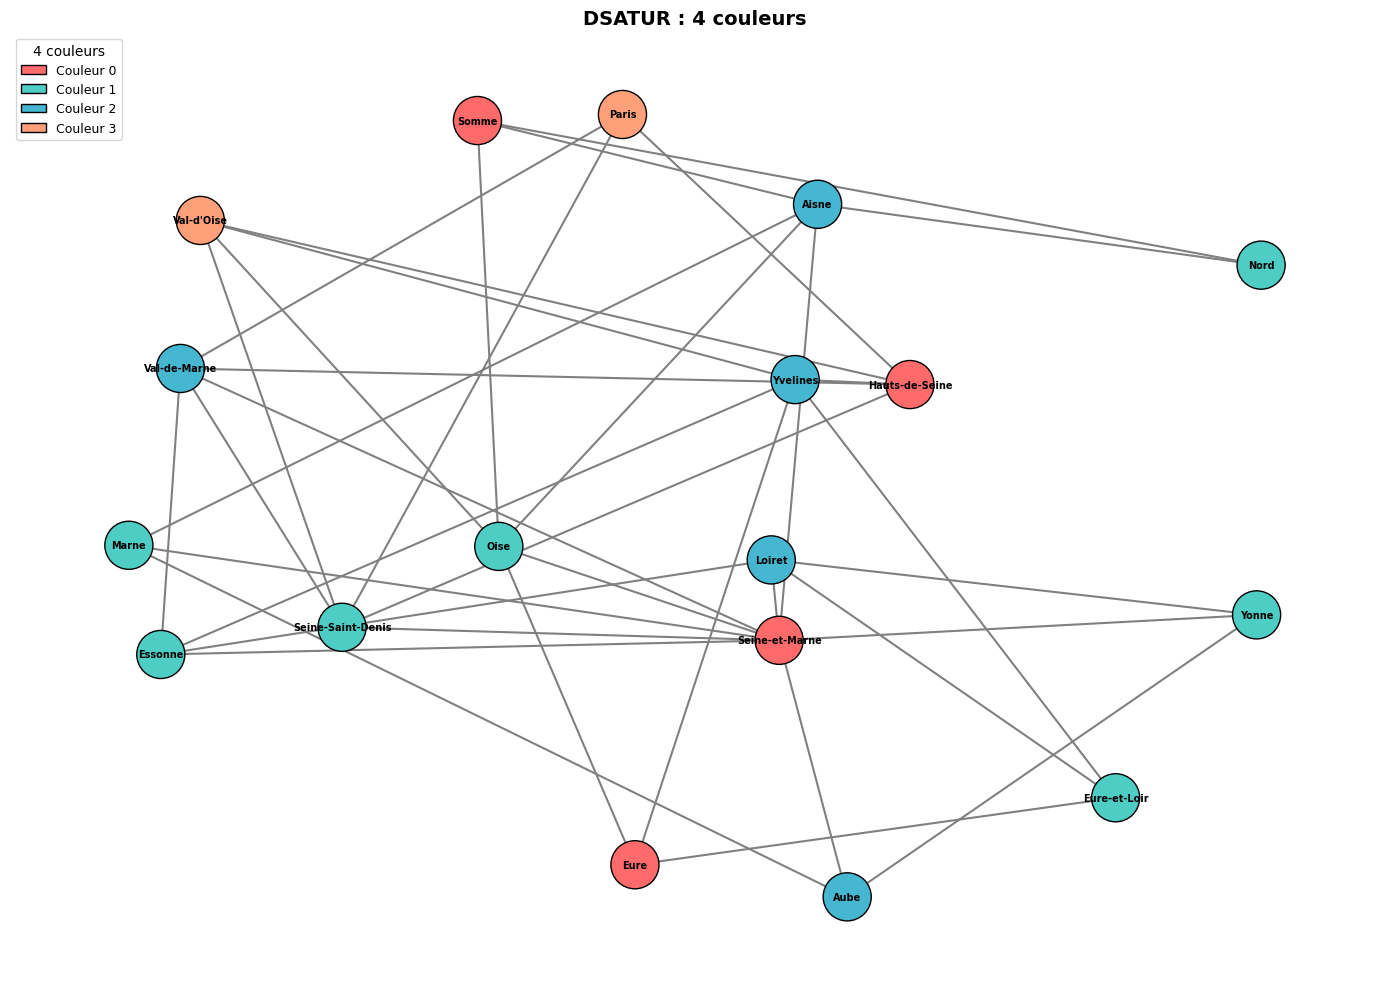

In [9]:
# Visualisation de la coloration DSATUR
draw_graph(dept_graph, coloring_dsatur,
           title=f"DSATUR : {n_colors_dsatur} couleurs")
plt.show()

### Comparaison Greedy vs DSATUR sur le graphe de Petersen

Le **graphe de Petersen** est un graphe classique en theorie des graphes : 10 sommets, 15 aretes, 3-regulier (chaque sommet a exactement 3 voisins). Son nombre chromatique est $\chi = 3$. C'est un bon test pour nos algorithmes.

Graphe de Petersen (chi = 3)
Algorithme                       Couleurs
---------------------------------------------
Greedy (defaut)                         3
Greedy (degre decroissant)              3
DSATUR                                  3
Optimal (chi)                           3


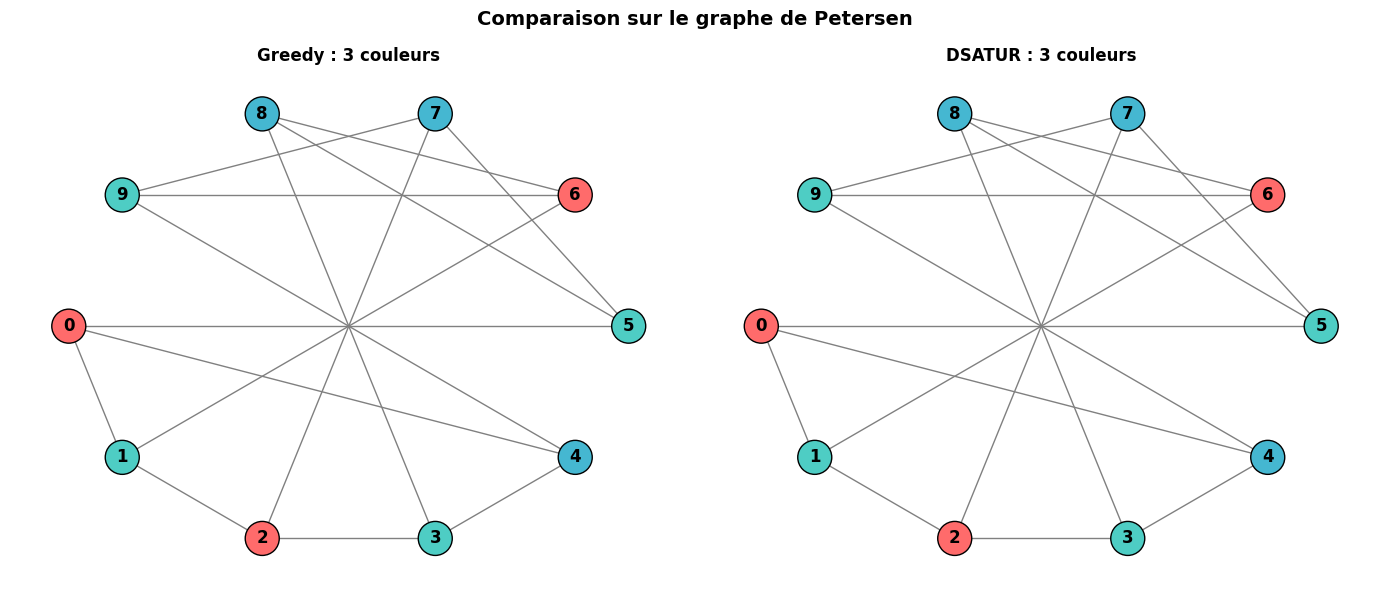

In [10]:
# Test sur le graphe de Petersen
petersen = nx.petersen_graph()

# Greedy avec differents ordres
greedy_default, n_gd = greedy_coloring(petersen)
greedy_deg_desc, n_gdd = greedy_coloring(petersen, order_by_degree_desc(petersen))

# DSATUR
dsatur_pet, n_ds = dsatur_coloring(petersen)

print("Graphe de Petersen (chi = 3)")
print("=" * 45)
print(f"{'Algorithme':<30} {'Couleurs':>10}")
print("-" * 45)
print(f"{'Greedy (defaut)':<30} {n_gd:>10}")
print(f"{'Greedy (degre decroissant)':<30} {n_gdd:>10}")
print(f"{'DSATUR':<30} {n_ds:>10}")
print(f"{'Optimal (chi)':<30} {'3':>10}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_petersen = nx.shell_layout(petersen)

palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Greedy
colors_g = [palette[greedy_default[n] % len(palette)] for n in petersen.nodes()]
nx.draw(petersen, pos_petersen, ax=axes[0], with_labels=True,
        node_color=colors_g, node_size=600, font_weight='bold',
        edge_color='gray', edgecolors='black')
axes[0].set_title(f"Greedy : {n_gd} couleurs", fontweight='bold')

# DSATUR
colors_d = [palette[dsatur_pet[n] % len(palette)] for n in petersen.nodes()]
nx.draw(petersen, pos_petersen, ax=axes[1], with_labels=True,
        node_color=colors_d, node_size=600, font_weight='bold',
        edge_color='gray', edgecolors='black')
axes[1].set_title(f"DSATUR : {n_ds} couleurs", fontweight='bold')

plt.suptitle("Comparaison sur le graphe de Petersen", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : Petersen

| Algorithme | Couleurs | Optimal ? |
|------------|----------|-----------|
| Greedy (defaut) | 3-4 | Peut echouer |
| DSATUR | 3 | Souvent optimal sur les petits graphes |

**Points cles** :
1. DSATUR trouve generalement l'optimal sur les graphes de taille moderee
2. Le greedy peut echouer meme sur un graphe 3-regulier simple
3. Cependant, DSATUR n'est pas garanti optimal en general (c'est une heuristique)

---

## 5. Approche 3 : OR-Tools CP-SAT (~8 min)

Pour **prouver** l'optimalite, nous utilisons le solveur **CP-SAT** de Google OR-Tools. Contrairement aux heuristiques, CP-SAT explore systematiquement l'espace de recherche et peut garantir que la solution trouvee utilise le nombre minimum de couleurs.

### Modelisation CP-SAT

| Element | Modelisation |
|---------|-------------|
| Variable $x_v$ | `model.new_int_var(0, k-1, f'color_{v}')` pour chaque sommet $v$ |
| Contrainte | `model.add(x_u != x_v)` pour chaque arete $(u, v)$ |
| Objectif | Minimiser $k$ (nombre de couleurs) |

Pour minimiser $k$, nous introduisons une variable `max_color` et contraignons chaque `x_v <= max_color`, puis nous minimisons `max_color`.

In [11]:
def cpsat_coloring(G, max_colors=None, find_all=False, time_limit=30):
    """Coloration optimale par OR-Tools CP-SAT.
    
    Args:
        G: graphe NetworkX
        max_colors: nombre maximum de couleurs (si None, utilise degre_max + 1)
        find_all: si True, enumere toutes les solutions optimales (limite a 100)
        time_limit: limite de temps en secondes
    
    Returns:
        coloring: dict sommet -> couleur
        n_colors: nombre chromatique
        stats: dict avec statistiques du solveur
    """
    if max_colors is None:
        max_colors = max(dict(G.degree()).values()) + 1
    
    model = cp_model.CpModel()
    
    # Variables : couleur de chaque sommet
    color_vars = {}
    for v in G.nodes():
        color_vars[v] = model.new_int_var(0, max_colors - 1, f'color_{v}')
    
    # Variable objectif : nombre max de couleur utilisee
    max_color_var = model.new_int_var(0, max_colors - 1, 'max_color')
    for v in G.nodes():
        model.add(color_vars[v] <= max_color_var)
    
    # Contraintes : sommets adjacents ont des couleurs differentes
    for u, v in G.edges():
        model.add(color_vars[u] != color_vars[v])
    
    # Objectif : minimiser le nombre de couleurs
    model.minimize(max_color_var)
    
    # Brisure de symetrie : fixer la couleur du premier sommet
    first_node = list(G.nodes())[0]
    model.add(color_vars[first_node] == 0)
    
    # Resolution
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    
    if find_all:
        # Enumerer les solutions
        class SolutionCounter(cp_model.CpSolverSolutionCallback):
            def __init__(self, color_vars):
                cp_model.CpSolverSolutionCallback.__init__(self)
                self._color_vars = color_vars
                self.solutions = []
            
            def on_solution_callback(self):
                sol = {v: self.value(cv) for v, cv in self._color_vars.items()}
                self.solutions.append(sol)
                if len(self.solutions) >= 100:
                    self.stop_search()
        
        callback = SolutionCounter(color_vars)
        solver.parameters.enumerate_all_solutions = True
        status = solver.solve(model, callback)
        
        stats = {
            'status': solver.status_name(status),
            'time_ms': solver.wall_time * 1000,
            'branches': solver.num_branches,
            'conflicts': solver.num_conflicts,
            'n_solutions': len(callback.solutions)
        }
        
        if callback.solutions:
            best = callback.solutions[0]
            n_colors = max(best.values()) + 1
            return best, n_colors, stats
        return None, 0, stats
    else:
        status = solver.solve(model)
        
        stats = {
            'status': solver.status_name(status),
            'time_ms': solver.wall_time * 1000,
            'branches': solver.num_branches,
            'conflicts': solver.num_conflicts,
        }
        
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            coloring = {v: solver.value(cv) for v, cv in color_vars.items()}
            n_colors = solver.value(max_color_var) + 1
            stats['optimal'] = (status == cp_model.OPTIMAL)
            return coloring, n_colors, stats
        else:
            return None, 0, stats

print("Fonction cpsat_coloring definie.")

Fonction cpsat_coloring definie.


Appliquons CP-SAT au graphe des departements et examinons les statistiques du solveur.

In [12]:
# Resolution optimale des departements
coloring_cpsat, n_colors_cpsat, stats_cpsat = cpsat_coloring(dept_graph)
valid, _ = validate_coloring(dept_graph, coloring_cpsat)

print("Coloration CP-SAT (optimale)")
print("=" * 50)
print(f"Nombre chromatique   : chi(G) = {n_colors_cpsat}")
print(f"Valide               : {valid}")
print(f"Statut               : {stats_cpsat['status']}")
print(f"Temps                : {stats_cpsat['time_ms']:.1f} ms")
print(f"Branches explorees   : {stats_cpsat['branches']}")
print(f"Conflits detectes    : {stats_cpsat['conflicts']}")
print(f"\nAffectation optimale :")
for dept, color in sorted(coloring_cpsat.items(), key=lambda x: x[1]):
    print(f"  {dept:<22} -> couleur {color}")

Coloration CP-SAT (optimale)
Nombre chromatique   : chi(G) = 4
Valide               : True
Statut               : OPTIMAL
Temps                : 23.5 ms
Branches explorees   : 0
Conflits detectes    : 0

Affectation optimale :
  Paris                  -> couleur 0
  Val-d'Oise             -> couleur 0
  Essonne                -> couleur 0
  Eure-et-Loir           -> couleur 0
  Yonne                  -> couleur 0
  Somme                  -> couleur 0
  Seine-Saint-Denis      -> couleur 1
  Loiret                 -> couleur 1
  Eure                   -> couleur 1
  Aisne                  -> couleur 1
  Aube                   -> couleur 1
  Val-de-Marne           -> couleur 2
  Yvelines               -> couleur 2
  Oise                   -> couleur 2
  Marne                  -> couleur 2
  Nord                   -> couleur 2
  Hauts-de-Seine         -> couleur 3
  Seine-et-Marne         -> couleur 3


### Interpretation : resultat CP-SAT

| Mesure | Valeur | Signification |
|--------|--------|---------------|
| Nombre chromatique | $\chi(G)$ | Nombre **minimum** de couleurs, prouve par le solveur |
| Statut OPTIMAL | Oui | La solution est prouvee optimale |
| Temps | Quelques ms | CP-SAT est tres efficace sur les graphes de taille moderee |

**Points cles** :
1. CP-SAT **prouve** que le resultat est optimal, contrairement aux heuristiques
2. Le graphe etant planaire, on s'attend a $\chi(G) \leq 4$ (theoreme des quatre couleurs)
3. La brisure de symetrie (fixer la couleur du premier sommet) accelere la resolution en eliminant les permutations de couleurs equivalentes

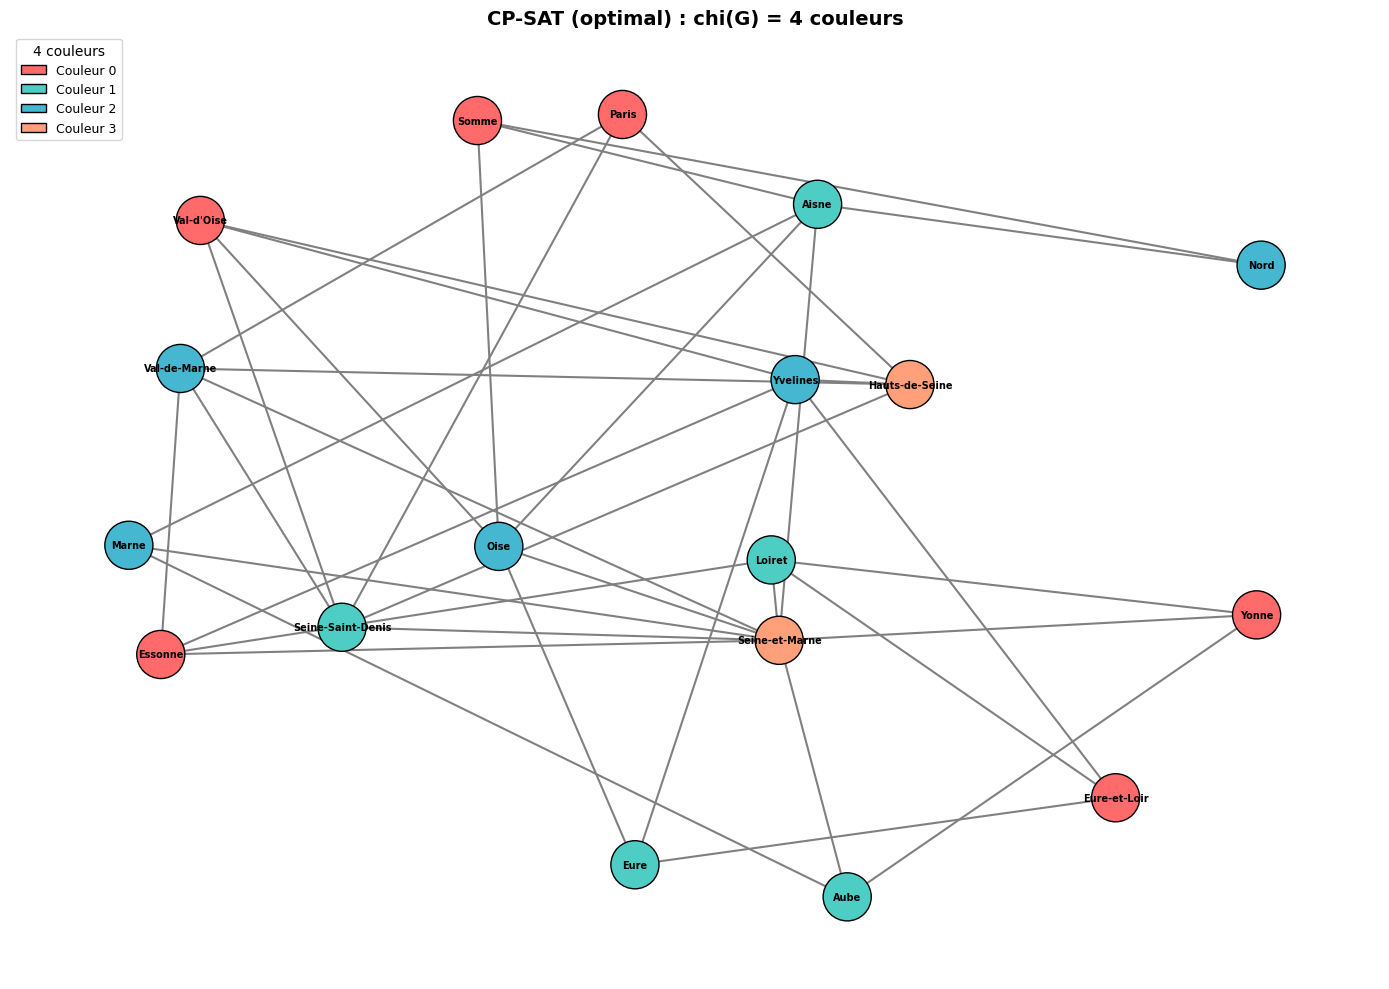

In [13]:
# Visualisation de la coloration optimale
draw_graph(dept_graph, coloring_cpsat,
           title=f"CP-SAT (optimal) : chi(G) = {n_colors_cpsat} couleurs")
plt.show()

### Enumeration des solutions sur un petit graphe

Pour un petit graphe, CP-SAT peut enumerer **toutes** les solutions optimales. Cela permet de voir combien de colorations differentes utilisent le nombre minimum de couleurs.

In [14]:
# Enumeration des solutions sur le graphe de Petersen
coloring_pet, n_pet, stats_pet = cpsat_coloring(petersen, find_all=True)

print(f"Graphe de Petersen : chi = {n_pet}")
print(f"Nombre de solutions trouvees : {stats_pet['n_solutions']}")
print(f"Temps : {stats_pet['time_ms']:.1f} ms")
print(f"\nPremiere solution : {coloring_pet}")

# Verification
valid_pet, _ = validate_coloring(petersen, coloring_pet)
print(f"Valide : {valid_pet}")

Graphe de Petersen : chi = 4
Nombre de solutions trouvees : 2
Temps : 3.9 ms

Premiere solution : {0: 0, 1: 1, 2: 0, 3: 1, 4: 3, 5: 3, 6: 3, 7: 1, 8: 0, 9: 0}
Valide : True


---

## 6. Benchmark et visualisation (~6 min)

Comparons maintenant les trois algorithmes sur des graphes de taille croissante. Nous utilisons des **graphes aleatoires** $G(n, p)$ (modele d'Erdos-Renyi) ou chaque arete existe avec probabilite $p$.

In [15]:
# Comparaison des 3 approches sur les departements

def run_all_algorithms(G, graph_name="Graphe"):
    """Execute les 3 algorithmes et retourne les resultats."""
    results = []
    
    # Greedy (degre decroissant = Welsh-Powell)
    start = time.time()
    col_g, n_g = greedy_coloring(G, order_by_degree_desc(G))
    t_g = (time.time() - start) * 1000
    results.append({
        'algorithm': 'Greedy (Welsh-Powell)',
        'colors': n_g,
        'time_ms': round(t_g, 2),
        'optimal': '?',
        'nodes_expanded': '-',
        'solution_found': True
    })
    
    # DSATUR
    start = time.time()
    col_d, n_d = dsatur_coloring(G)
    t_d = (time.time() - start) * 1000
    results.append({
        'algorithm': 'DSATUR',
        'colors': n_d,
        'time_ms': round(t_d, 2),
        'optimal': '?',
        'nodes_expanded': '-',
        'solution_found': True
    })
    
    # CP-SAT
    start = time.time()
    col_c, n_c, stats = cpsat_coloring(G, time_limit=30)
    t_c = (time.time() - start) * 1000
    results.append({
        'algorithm': 'CP-SAT (OR-Tools)',
        'colors': n_c,
        'time_ms': round(t_c, 2),
        'optimal': 'Oui' if stats.get('optimal') else 'Non',
        'nodes_expanded': stats.get('branches', '-'),
        'solution_found': col_c is not None
    })
    
    # Marquer l'optimalite des heuristiques
    if n_c > 0:
        results[0]['optimal'] = 'Oui' if n_g == n_c else 'Non'
        results[1]['optimal'] = 'Oui' if n_d == n_c else 'Non'
    
    return results


# Benchmark sur les departements
dept_results = run_all_algorithms(dept_graph, "Departements")

print("Comparaison des 3 approches - Departements francais")
print("=" * 65)
print(f"{'Algorithme':<25} {'Couleurs':>10} {'Temps (ms)':>12} {'Optimal':>10}")
print("-" * 65)
for r in dept_results:
    print(f"{r['algorithm']:<25} {r['colors']:>10} {r['time_ms']:>12} {r['optimal']:>10}")
print("=" * 65)

Comparaison des 3 approches - Departements francais
Algorithme                  Couleurs   Temps (ms)    Optimal
-----------------------------------------------------------------
Greedy (Welsh-Powell)              4         0.03        Oui
DSATUR                             4         0.07        Oui
CP-SAT (OR-Tools)                  4        14.84        Oui


### Benchmark sur des graphes aleatoires de taille croissante

Nous testons sur des graphes $G(n, 0.3)$ avec $n$ variant de 20 a 200, pour observer comment chaque algorithme passe a l'echelle.

In [16]:
# Benchmark sur graphes aleatoires G(n, p)
graph_sizes = [20, 40, 60, 80, 100, 150, 200]
p = 0.3  # probabilite d'arete

benchmark_data = {
    'n': [],
    'greedy_colors': [], 'greedy_time': [],
    'dsatur_colors': [], 'dsatur_time': [],
    'cpsat_colors': [], 'cpsat_time': [],
}

print(f"Benchmark sur graphes aleatoires G(n, {p})")
print("=" * 80)
print(f"{'n':>5} {'|':>2} {'Greedy':>8} {'t(ms)':>8} {'|':>2} {'DSATUR':>8} {'t(ms)':>8} {'|':>2} {'CP-SAT':>8} {'t(ms)':>10}")
print("-" * 80)

for n in graph_sizes:
    G = nx.erdos_renyi_graph(n, p, seed=42)
    
    # Greedy
    start = time.time()
    _, n_g = greedy_coloring(G, order_by_degree_desc(G))
    t_g = (time.time() - start) * 1000
    
    # DSATUR
    start = time.time()
    _, n_d = dsatur_coloring(G)
    t_d = (time.time() - start) * 1000
    
    # CP-SAT (avec timeout court pour les grands graphes)
    start = time.time()
    _, n_c, stats = cpsat_coloring(G, time_limit=10)
    t_c = (time.time() - start) * 1000
    
    benchmark_data['n'].append(n)
    benchmark_data['greedy_colors'].append(n_g)
    benchmark_data['greedy_time'].append(t_g)
    benchmark_data['dsatur_colors'].append(n_d)
    benchmark_data['dsatur_time'].append(t_d)
    benchmark_data['cpsat_colors'].append(n_c)
    benchmark_data['cpsat_time'].append(t_c)
    
    print(f"{n:>5} {'|':>2} {n_g:>8} {t_g:>8.1f} {'|':>2} {n_d:>8} {t_d:>8.1f} {'|':>2} {n_c:>8} {t_c:>10.1f}")

print("=" * 80)

Benchmark sur graphes aleatoires G(n, 0.3)
    n  |   Greedy    t(ms)  |   DSATUR    t(ms)  |   CP-SAT      t(ms)
--------------------------------------------------------------------------------
   20  |        5      0.0  |        5      0.1  |        5       15.8


   40  |        8      0.1  |        7      0.4  |        6      165.8


   60  |        9      0.2  |        7      1.7  |        7    10077.0


   80  |       11      0.2  |       10      1.1  |        8    10107.3


  100  |       12      0.2  |       11      2.0  |       10    10130.0


  150  |       17      0.6  |       15      6.1  |       14    10138.1


  200  |       22      0.8  |       19      7.9  |       18    10177.8


Visualisons les resultats du benchmark avec des graphiques comparatifs : qualite de la coloration (nombre de couleurs) et temps de resolution en fonction de la taille du graphe.

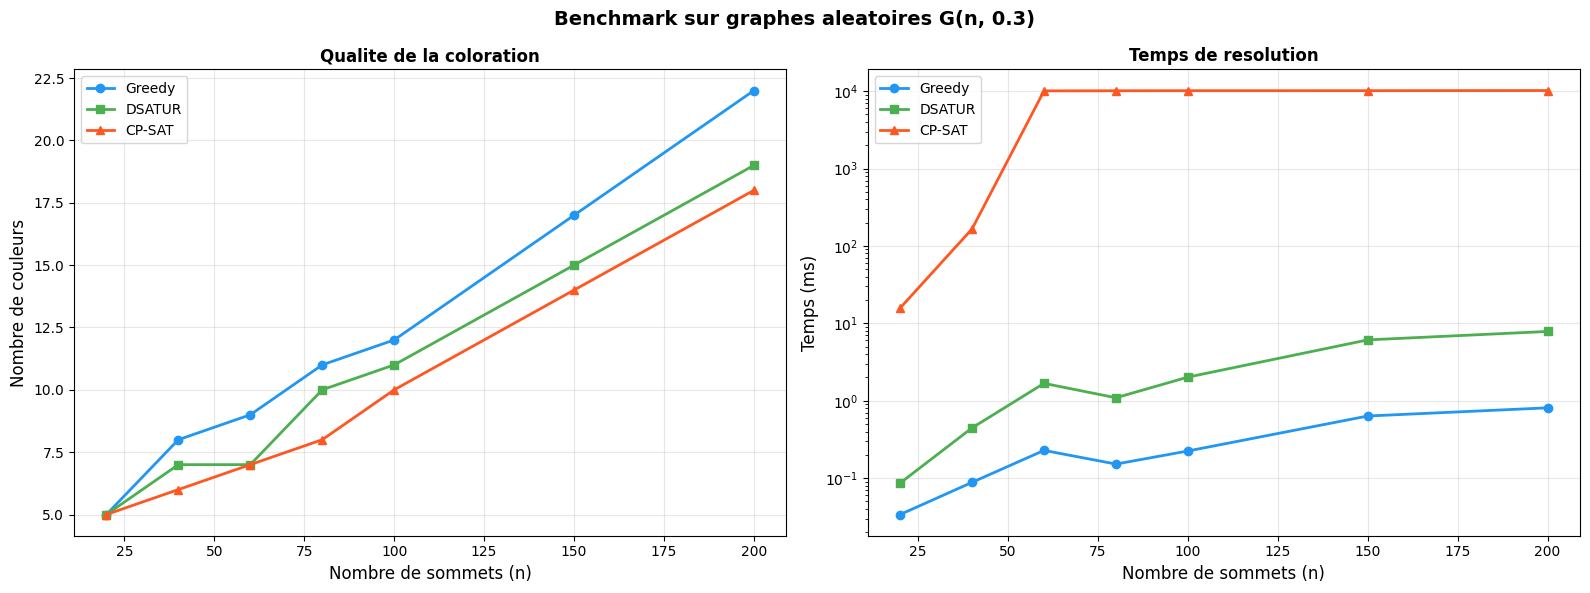

In [17]:
# Visualisation du benchmark
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ns = benchmark_data['n']

# Nombre de couleurs
axes[0].plot(ns, benchmark_data['greedy_colors'], 'o-', label='Greedy', color='#2196F3', linewidth=2)
axes[0].plot(ns, benchmark_data['dsatur_colors'], 's-', label='DSATUR', color='#4CAF50', linewidth=2)
axes[0].plot(ns, benchmark_data['cpsat_colors'], '^-', label='CP-SAT', color='#FF5722', linewidth=2)
axes[0].set_xlabel('Nombre de sommets (n)', fontsize=12)
axes[0].set_ylabel('Nombre de couleurs', fontsize=12)
axes[0].set_title('Qualite de la coloration', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Temps d'execution
axes[1].plot(ns, benchmark_data['greedy_time'], 'o-', label='Greedy', color='#2196F3', linewidth=2)
axes[1].plot(ns, benchmark_data['dsatur_time'], 's-', label='DSATUR', color='#4CAF50', linewidth=2)
axes[1].plot(ns, benchmark_data['cpsat_time'], '^-', label='CP-SAT', color='#FF5722', linewidth=2)
axes[1].set_xlabel('Nombre de sommets (n)', fontsize=12)
axes[1].set_ylabel('Temps (ms)', fontsize=12)
axes[1].set_title('Temps de resolution', fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Benchmark sur graphes aleatoires G(n, {p})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : benchmark comparatif

| Algorithme | Qualite | Vitesse | Passage a l'echelle | Garantie |
|------------|---------|---------|---------------------|----------|
| **Greedy** | Acceptable (+1-2 couleurs) | Tres rapide $O(V+E)$ | Excellent | Aucune |
| **DSATUR** | Bonne (souvent optimal) | Rapide $O(V^2)$ | Bon | Aucune |
| **CP-SAT** | Optimal | Lent pour grands graphes | Limite (~200 sommets) | Prouve optimal |

**Points cles** :
1. **DSATUR** offre le meilleur compromis qualite/vitesse pour les problemes pratiques
2. **CP-SAT** est indispensable quand on a besoin de la **preuve d'optimalite**
3. **Greedy** est utile comme initialisation rapide ou quand la vitesse prime sur la qualite
4. Le temps de CP-SAT croit exponentiellement avec la taille, ce qui est attendu pour un probleme NP-difficile

> **En pratique** : on utilise souvent DSATUR pour obtenir une bonne solution rapidement, puis CP-SAT pour verifier si on peut faire mieux (ou prouver l'optimalite sur les instances critiques).

### Visualisation finale : carte des departements

Affichons la coloration optimale (CP-SAT) avec une mise en forme soignee.

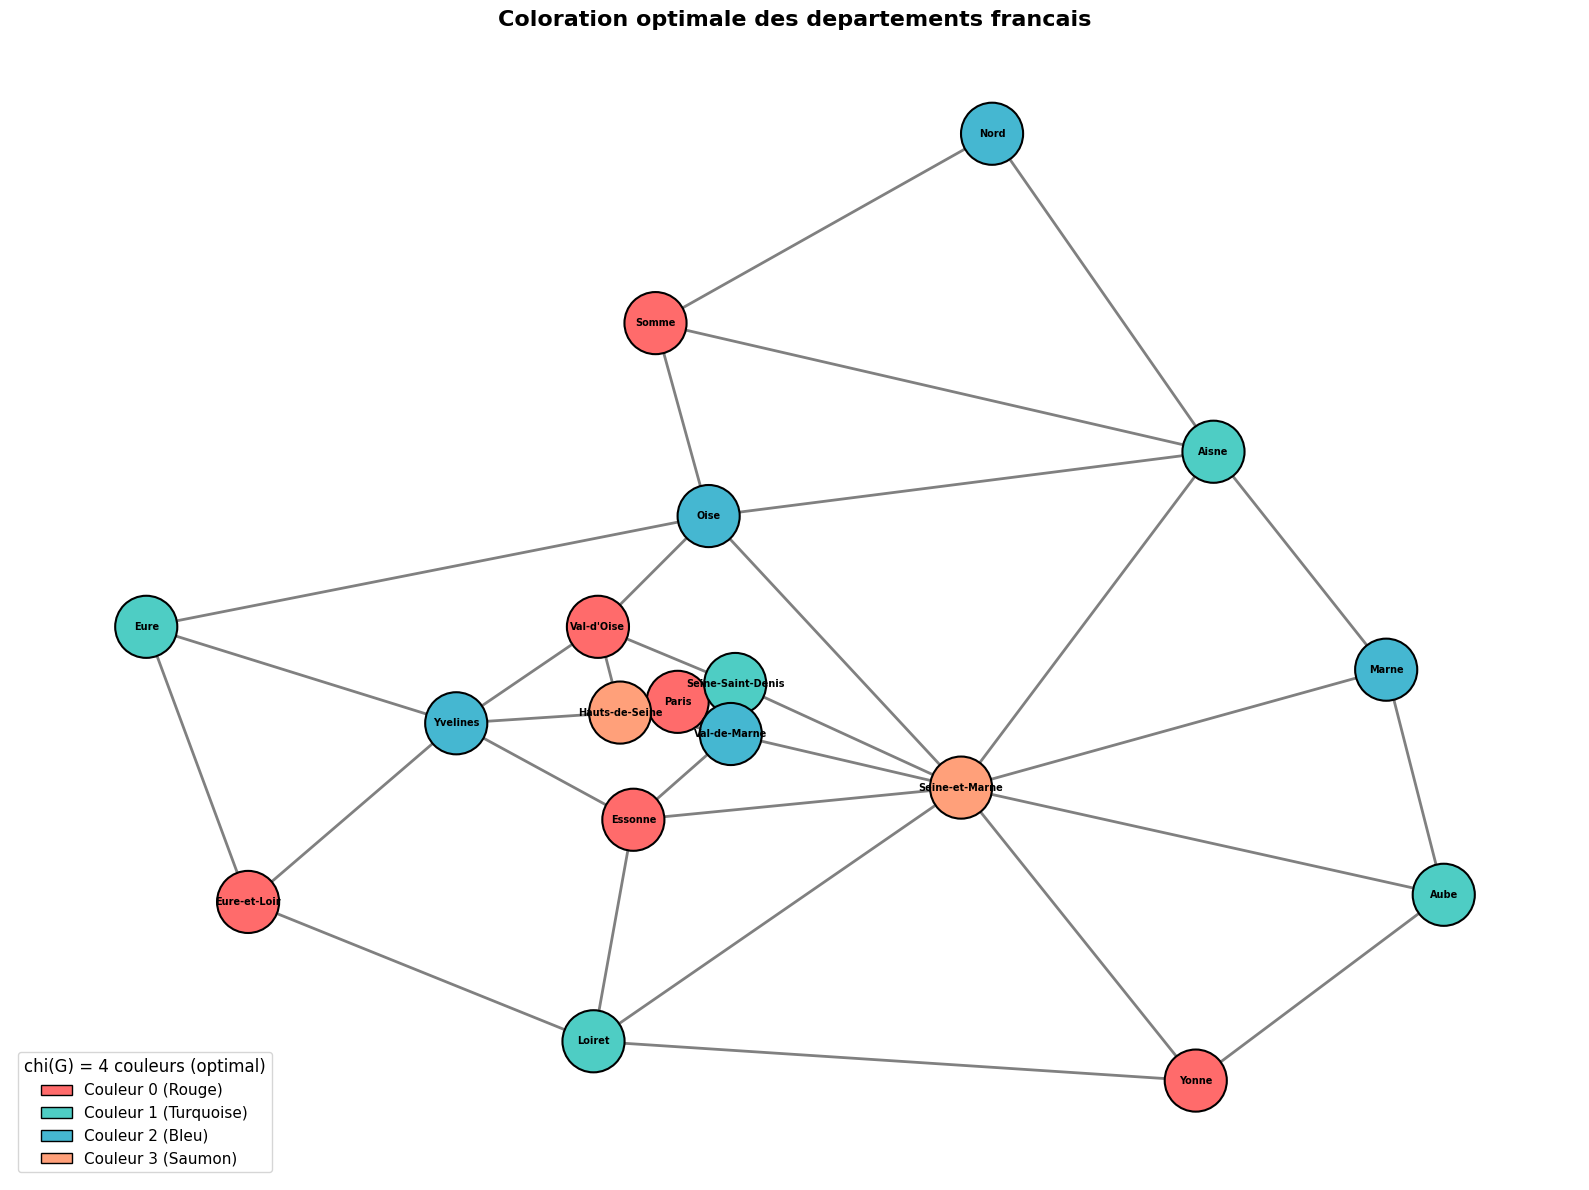

In [18]:
# Carte finale des departements avec coloration optimale
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8',
           '#F7DC6F', '#BB8FCE', '#85C1E9']
color_names = ['Rouge', 'Turquoise', 'Bleu', 'Saumon', 'Menthe',
               'Jaune', 'Violet', 'Bleu pale']

# Positions geographiques approximatives (longitude, latitude simplifiees)
geo_positions = {
    "Paris":             (2.35, 48.86),
    "Hauts-de-Seine":    (2.22, 48.83),
    "Seine-Saint-Denis": (2.48, 48.91),
    "Val-de-Marne":      (2.47, 48.77),
    "Essonne":           (2.25, 48.53),
    "Yvelines":          (1.85, 48.80),
    "Val-d'Oise":        (2.17, 49.07),
    "Seine-et-Marne":    (2.99, 48.62),
    "Oise":              (2.42, 49.38),
    "Aisne":             (3.56, 49.56),
    "Loiret":            (2.16, 47.91),
    "Eure-et-Loir":      (1.38, 48.30),
    "Eure":              (1.15, 49.07),
    "Marne":             (3.95, 48.95),
    "Aube":              (4.08, 48.32),
    "Yonne":             (3.52, 47.80),
    "Somme":             (2.30, 49.92),
    "Nord":              (3.06, 50.45),
}

node_colors = [palette[coloring_cpsat.get(node, 0) % len(palette)]
               for node in dept_graph.nodes()]

nx.draw(dept_graph, geo_positions, ax=ax,
        with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=7,
        font_weight='bold',
        edge_color='gray',
        width=2.0,
        edgecolors='black',
        linewidths=1.5,
        style='solid')

# Legende
legend_elements = [
    mpatches.Patch(facecolor=palette[i], edgecolor='black',
                   label=f'Couleur {i} ({color_names[i]})')
    for i in range(n_colors_cpsat)
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=11,
          title=f"chi(G) = {n_colors_cpsat} couleurs (optimal)",
          title_fontsize=12)

ax.set_title("Coloration optimale des departements francais",
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 7. Exercices

### Exercice 1 : Colorier les etats americains

Construisez un graphe simplifie de 10-12 etats americains contigus (par exemple la region des Grands Lacs : Ohio, Indiana, Illinois, Michigan, Wisconsin, Minnesota, Iowa, Missouri, Kentucky, West Virginia). Appliquez les trois algorithmes et comparez.

**Indice** : vous pouvez trouver les adjacences sur Wikipedia ("list of US states by border").

In [19]:
# Exercice 1 : Colorier les etats americains

# A COMPLETER
# us_adjacency = {
#     "Ohio":          ["Indiana", "Kentucky", "West Virginia", "Michigan"],
#     "Indiana":       ["Ohio", "Illinois", "Kentucky", "Michigan"],
#     "Illinois":      ["Indiana", "Iowa", "Missouri", "Kentucky", "Wisconsin"],
#     ...
# }
# 
# us_graph = nx.Graph()
# for state, neighbors in us_adjacency.items():
#     for n in neighbors:
#         us_graph.add_edge(state, n)
# 
# # Appliquer les 3 algorithmes
# us_results = run_all_algorithms(us_graph, "US States")
# for r in us_results:
#     print(f"{r['algorithm']:<25} {r['colors']:>5} couleurs  ({r['optimal']})")

### Exercice 2 : Borne superieure du greedy et planairite

Le theoreme des quatre couleurs garantit que tout graphe **planaire** est 4-coloriable. Cependant, le greedy ne le garantit pas.

**Questions** :
1. Quel est le nombre maximum de couleurs que le greedy peut utiliser sur un graphe planaire a $n$ sommets ?
2. Construisez un graphe planaire ou le greedy (avec un mauvais ordre) utilise 5 ou 6 couleurs
3. Montrez que l'algorithme de Welsh-Powell (greedy par degre decroissant) utilise au plus $\Delta(G) + 1$ couleurs. Quelle est cette borne pour un graphe planaire ?

**Indice** : un graphe planaire simple a au plus $3n - 6$ aretes, donc le degre moyen est au plus $6 - 12/n < 6$.

In [20]:
# Exercice 2 : Exploration des bornes

# A COMPLETER
# Construisez un graphe planaire et montrez que le greedy peut utiliser
# plus de 4 couleurs avec un mauvais ordre de sommets.
#
# Suggestion : graphe icosaedre (12 sommets, 30 aretes, 5-regulier, planaire)
# icosahedron = nx.icosahedral_graph()
# print(f"Planaire : {nx.is_planar(icosahedron)}")
# print(f"Degre max : {max(dict(icosahedron.degree()).values())}")
#
# # Tester differents ordres
# for seed in range(20):
#     order = order_random(icosahedron, seed=seed)
#     _, n = greedy_coloring(icosahedron, order)
#     if n > 4:
#         print(f"  Seed {seed} : {n} couleurs (> 4 !)")

### Exercice 3 : Implementer Welsh-Powell et comparer avec DSATUR

L'algorithme de **Welsh-Powell** (1967) est un greedy ou les sommets sont tries par **degre decroissant** avant le parcours. C'est un cas particulier de notre `greedy_coloring` avec `order_by_degree_desc`.

Implementez une version optimisee qui colorie les sommets par "couches" :
1. Trier les sommets par degre decroissant
2. Prendre le premier sommet non colorie, lui attribuer la couleur $c$
3. Parcourir les sommets restants : si un sommet non colorie n'est adjacent a aucun sommet de couleur $c$, le colorier en $c$
4. Repeter avec la couleur suivante

Comparez les resultats avec DSATUR sur 5 graphes aleatoires $G(50, 0.3)$.

In [21]:
# Exercice 3 : Welsh-Powell par couches

# A COMPLETER
# def welsh_powell_coloring(G):
#     """Algorithme de Welsh-Powell par couches."""
#     coloring = {}
#     sorted_vertices = sorted(G.nodes(), key=lambda v: G.degree(v), reverse=True)
#     uncolored = set(sorted_vertices)
#     color = 0
#     
#     while uncolored:
#         # Prendre le premier non colorie
#         layer = []
#         for v in sorted_vertices:
#             if v not in uncolored:
#                 continue
#             # Verifier si v est adjacent a un sommet deja dans cette couche
#             conflict = False
#             for u in layer:
#                 if G.has_edge(u, v):
#                     conflict = True
#                     break
#             if not conflict:
#                 layer.append(v)
#                 coloring[v] = color
#                 uncolored.remove(v)
#         color += 1
#     
#     n_colors = max(coloring.values()) + 1
#     return coloring, n_colors
#
# # Comparaison avec DSATUR
# for i in range(5):
#     G = nx.erdos_renyi_graph(50, 0.3, seed=i)
#     _, n_wp = welsh_powell_coloring(G)
#     _, n_ds = dsatur_coloring(G)
#     _, n_cp, _ = cpsat_coloring(G)
#     print(f"Graphe {i}: Welsh-Powell={n_wp}, DSATUR={n_ds}, Optimal={n_cp}")

---

## Recapitulatif

### Resume des algorithmes

| Algorithme | Type | Complexite | Qualite | Garantie |
|------------|------|-----------|---------|----------|
| **Greedy** | Heuristique constructive | $O(V + E)$ | $\leq \Delta(G) + 1$ couleurs | Borne superieure |
| **DSATUR** | Heuristique adaptative | $O(V^2)$ | Souvent optimal | Aucune (exact pour bipartis) |
| **CP-SAT** | Solveur exact | Exponentiel pire cas | Optimal ($\chi(G)$) | Preuve d'optimalite |

### Ce que nous avons appris

1. La **coloration de graphe** est un probleme NP-difficile fondamental avec de nombreuses applications
2. L'**ordre des sommets** a un impact majeur sur la qualite de la coloration gloutonne
3. **DSATUR** adapte dynamiquement l'ordre en privilegiant les sommets les plus satures (analogie avec MRV en CSP)
4. **CP-SAT** garantit l'optimalite mais ne passe pas a l'echelle sur les grands graphes
5. Le **theoreme des quatre couleurs** borne le nombre chromatique des graphes planaires

### Pour aller plus loin

- **Tabu Search** : ameliorer une coloration par recherche locale avec liste tabu
- **Branch and Bound** : algorithme exact plus efficace que la brute force
- **Coloration de graphes d'intervalles** : cas polynomial important en planification
- **Coloration fractionnaire** : relaxation LP du probleme de coloration

### References

- Brelaz, D. (1979). "New methods to color the vertices of a graph". *Communications of the ACM*, 22(4), 251-256.
- Welsh, D. J. A. & Powell, M. B. (1967). "An upper bound for the chromatic number of a graph". *The Computer Journal*, 10(1), 85-86.
- Appel, K. & Haken, W. (1976). "Every planar map is four colorable". *Bulletin of the AMS*, 82(5), 711-712.
- Karp, R. M. (1972). "Reducibility among combinatorial problems". *Complexity of Computer Computations*, 85-103.

---

**Navigation** : [<< App-1 NQueens](App-1-NQueens.ipynb) | [Index](../README.md) | [App-3 NurseScheduling >>](App-3-NurseScheduling.ipynb)